### Chapter 7.4 
# Energy Efficiency in IoT and Kleinrock's Power Metric
---
>(c) Tobias Hossfeld  (Aug 2021)<br><br>
> This script and the figures are part of the following book. The book is to be cited whenever the script is used (copyright CC BY-SA 4.0):<br>
> *Tran-Gia, P. & Hossfeld, T. (2021). 
Performance Modeling and Analysis of Communication Networks - A Lecture Note.
Würzburg University Press.*
> *https://doi.org/10.25972/WUP-978-3-95826-153-2*

---

The transmission of the sensor nodes to the IoT gateway is modeled in this chapter. The goal is to show how appropriate queueing models can be used to model various transmission schemes. The medium access control (MAC) schemes of the IoT nodes consider pure and slotted ALOHA as random access mechanism, perfect carrier-sense multiple access with collision avoidance (CSMA/CA) as well as energy-aware CSMA/CA with restricted accessibility. These mechanisms can be modeled as 

1. M/D/$\infty$ for ALOHA, 
2. M/D/1-$\infty$ for a perfect carrier-sense mechanism with collision avoidance, 
3. M/D/1-S for energy-aware CSMA/CA with restricted accessibility.


The different transmission schemes are compared in terms of the performance (throughput, success probability, response time) and the energy consumption. 

The IoT nodes are independently sending messages over the air interface. The aggregated arrival process is modeled as a Poisson process with rate $\lambda$. The messages are assumed to have constant size which requires time $b$ on the air interface (time on air, ToA) for the transmission from the IoT node to the IoT gateway. Note that the time on air depends on the configuration of the channel, e.g. the used spreading factor in case of LoRa, the payload of the message, the preamble length of messages, cyclic redundancy checks for error detection, etc. The time on air $b$ subsumes the effects in this model.

## Energy Efficiency Metric
The energy consumption depends on the response time $T$ for sending a message. To be more precise, the energy consumption is the integral of the power consumption over the time needed to send the message.
We may differentiate between the power consumption (1) for sending the message ($\gamma_b$) which takes time $b$ and (2) for waiting before sending ($\gamma_w$) which takes time $W$. Different values $\gamma_b$ and $\gamma_w$ for the power use (in Watt) are used. The energy consumption (in Joule = Watt $\cdot$ second) for a single message is then $\gamma_b b + \gamma_w W$, which is a linear function $f$ of the random variable $W$. Therefore, it is $E[f(W)] = f(E[W])$.

* Mean energy consumption for single sent message: $\Omega = \gamma_b b + \gamma_w E[W]$.

It is however more relevant to quantify the mean consumed energy per successfully received message, which is denoted by $\omega$. There are $m$ messages sent in total, from which $\psi \cdot m$ messages are successfully received. The energy consumption for $m$ messages is $m \cdot \Omega$ on average. Then $\omega$ is the mean energy consumption per received message, i.e., $\omega = \frac{m \Omega}{m \psi}$.

* Success probability $\psi$: probability that an arbitrary message is successfully transmitted to the IoT gateway.
* Energy consumption per received message: $\omega =  \displaystyle \frac{\Omega}{\psi}$.


Energy efficiency can be described as the ratio between the total number of packets received at the destination node (i.e. the IoT gateway) and the total energy consumption spent by the network to deliver these packets (i.e. the sensor nodes), see \cite{boyle2017energy}. In that sense, energy efficiency means how many messages are carried per joule. 
In this chapter, we normalize the amount of consumed energy by the energy consumption of a single message. Energy efficiency is then the ratio between _How many messages are received?_ and _How many messages could have been received regarding the total energy consumption?_. The energy efficiency $\eta$  takes values in the interval $[0;1]$. Maximum energy efficiency is reached ($\eta=1$), if all messages are received and require the minimum amount of energy $\gamma_b b$. A value $\eta=1/2$ may be interpreted in two ways: (a) 50\% of the messages are received, but all messages require the minimum energy consumption or (b)~all messages are received, but additional energy consumption is required for the successful delivery, e.g. due to waiting times.

* Energy efficiency: $\eta = \displaystyle \frac{\psi}{\Omega / ( \gamma_b b)} = \frac{\gamma_b b}{\omega} $.


## Perfect CSMA/CA with Restricted Accessibility: M/D/1-S
In high load situations, the perfect CSMA/CA suffers from large waiting times and high energy consumption. To this end, restricted accessibility is introduced which provides a control knob between blocked messages and energy efficiency. If there are already $S$ messages waiting, the IoT gateway rejects the requests and informs the IoT nodes that their request is blocked. If there are less than $S$ transmission requests waiting at the server, the IoT gateway accepts the request. The requests are served in order. The IoT nodes with accepted requests are waiting until the IoT gateway informs them. Then, the message will be sent over the air interface. There are no message collisions, but messages may be blocked which differs the system from the previous one.

The system can be modeled as a finite capacity queue and is denoted as M/D/1-S in Kendall's notation. We solve the M/D/1-S system numerically with the power method.

In [1]:
import numpy as np
from scipy import linalg
from scipy.stats import poisson

#%% M/D/1-S
def stateTransitionMatrix_MD1S(lam=2, b=1, S=5):
    rho = lam*b
    gam = poisson(rho)
        
    P = np.zeros((S+1,S+1))
    
    for j in range(S):
        P[0,j] = gam.pmf(j)
        
    for i in range(1,S+1):
        for j in range(i-1,S):
            P[i,j] = gam.pmf(j-i+1)
            
    P[:,S] = 1-np.sum(P, axis=1)

    return P


def powerMethod(P, eps=0.0000001):
    s1 = P.shape[0] # S+1
    Xnew = np.zeros(s1)
    Xnew[0] = 1
    
    X = np.ones(s1)
    i = np.arange(s1)
    while abs(Xnew.dot(i)-X.dot(i))>eps:
        X = Xnew
        Xnew = X.dot(P)        
    
    return Xnew

def leftEigenvector(P, eigenval=1):
    w, vl = linalg.eig(P, left=True, right=False)
    X = vl[:,np.argwhere(np.isclose(w,eigenval))[0][0]].T
    return X/X.sum()


def metrics_MD1S(lam=2, b=1, S=5, gamb=1.0, gamw=1.0):
    P = stateTransitionMatrix_MD1S(lam=lam, b=b, S=S)  
    X = powerMethod(P)
    rho = lam*b
    pB = (rho-1+X[0])/(rho+X[0])
    
    Xstar = np.zeros(S+2)
    Xstar[:S+1] = X/(rho+X[0])
    Xstar[-1] = pB
    
    i = np.arange(S+2)
    EX = Xstar.dot(i)
    
    ET = EX/((1-pB)*lam)
    EW = ET-b
    
    succProb = 1-pB
    throughput = succProb*lam
    
    energyConsumption = gamb*b+gamw*EW # Omega
    energyConsumptionRcvMsg = energyConsumption/succProb # omega per received message
    energyEfficiency = gamb*b/energyConsumptionRcvMsg
    
    return succProb, throughput, ET, energyConsumption, energyConsumptionRcvMsg, energyEfficiency

# M/GI/n-0
def erlangB(n,a):
    x = 1.0
    for i in range(1,n+1):
        x= 1.0/(1+(i/(a*x)))
    return x


### Visualization of Results: Success Probability

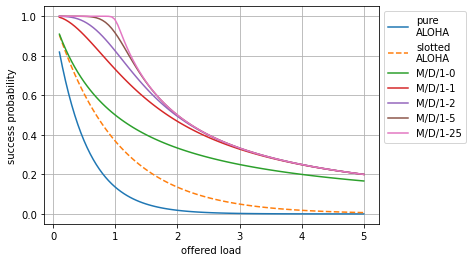

In [3]:
gamb=1.0
gamw=0.5

a = np.linspace(0.1,5,100)
S = [0, 1, 2, 5, 25]
md1s_succ=np.zeros((len(a), len(S)))
md1s_energyEfficiency=np.zeros((len(a), len(S)))

# computation
for i,s in enumerate(S):
    for j, rho in enumerate(a):
        b = 1.0
        lam = rho/b
        succProb, throughput, ET, energyConsumption, energyConsumptionRcvMsg, energyEfficiency = metrics_MD1S(lam=lam, b=b, S=s, gamb=gamb, gamw=gamw)
        md1s_succ[j,i] = succProb
        md1s_energyEfficiency[j,i] = energyEfficiency


# plot it
import matplotlib.pyplot as plt

plt.plot(a, np.exp(-2*a), label='pure\nALOHA')
plt.plot(a, np.exp(-a), '--', label='slotted\nALOHA')
for i,s in enumerate(S):
    plt.plot(a, md1s_succ[:,i], label=f'M/D/1-{s}')
plt.grid(which='major')
plt.ylabel('success probability')
plt.xlabel('offered load')
plt.legend(loc=2, bbox_to_anchor=(1, 1));        

### Visualization of Results: Energy Efficiency

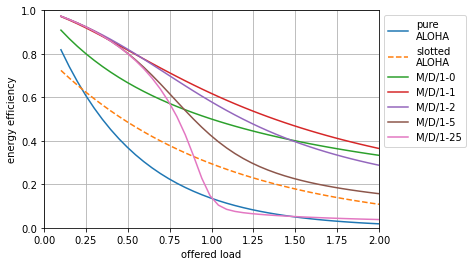

In [5]:
tf = lambda x: (gamb*b)/x 

plt.plot(a, tf(gamb*b*np.exp(2*a)), label='pure\nALOHA')
plt.plot(a, tf(b*(gamb+gamw/2)*np.exp(a)), '--',  label='slotted\nALOHA')
for i,s in enumerate(S):
    plt.plot(a, md1s_energyEfficiency[:,i], label=f'M/D/1-{s}')

plt.grid(which='major')
plt.ylabel('energy efficiency')
plt.xlabel('offered load')
plt.legend()
plt.ylim([0, 1])
plt.xlim([0, 2])
plt.legend(loc=2, bbox_to_anchor=(1, 1));

## Kleinrock’s Approach for Deriving the Operational Point

For the identification of the operational point, which is the number of waiting places $S$ for the M/D/1-S queueing system, we follow an approach by Kleinrock. He suggests the _Power metric_ in queueing systems as optimization metric to identify the knee of the curve. The power metric is the ratio of _goodness_ divided by_ badness_. Then, the optimization of power leads to a trade-off between maximizing _goodness_ while minimizing _badness_. In his original work, a single server system is considered with _goodness_ being the relative efficiency $G=\rho$ of the server, i.e., the fraction of time the server is being used. _Badness_ refers to the normalized response time $B=T/E[B]$ which should be minimal. The maximum value of the power metric $G/B$ is then the operational point.

For the IoT system and CSMA/CA with restricted accessibility, consider the ratio between energy efficiency $\eta$ and the counter success probability ($1-\psi)$. The maximum of the ratio $G/B=\eta/(1-\psi)$ corresponds to the operational point.

In [6]:
# compute the results
gamb=1.0
gamw=0.5

a = np.array([0.1, 0.5, 0.9, 1.0, 1.25, 1.5, 2.0])
S = np.arange(0,25)
md1s_succ=np.zeros((len(a), len(S)))
md1s_energyEfficiency=np.zeros((len(a), len(S)))

for i,s in enumerate(S):
    for j, rho in enumerate(a):
        b = 1.0
        lam = rho/b
        succProb, throughput, ET, energyConsumption, energyConsumptionRcvMsg, energyEfficiency = metrics_MD1S(lam=lam, b=b, S=s, gamb=gamb, gamw=gamw)
        md1s_succ[j,i] = succProb
        md1s_energyEfficiency[j,i] = energyEfficiency
    

 The following figure shows the ratio $G/B$ which is normalized with the maximum observed ratio per offered load $a$, depending on $S$.

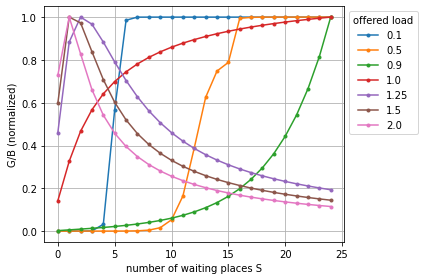

In [7]:
#####################################################
#%% Slope approach by Kleinrock: good/bad
#####################################################
for i, rho in enumerate(a):
    y = md1s_energyEfficiency[i,:]/(1-md1s_succ[i,:])     
    plt.plot(S, y/y.max(), '.-', label=rho)
plt.xlabel('number of waiting places S')
plt.ylabel('G/B (normalized)')
plt.grid(which='major')
plt.legend(loc=2, bbox_to_anchor=(1, 1), title='offered load');          
plt.tight_layout();